# Advection-Diffusion 2

* We've seen how central differences are good for diffusion and not so good for advection. 
* We used upwinding for advection to overcome unphysical oscillations.
* Here, we will follow Patankar and take advantage of an exact solution for advection-diffusion problems to build a unique, accurate method.



## 1-D, steady advection-diffusion equation

$$u\frac{d\phi}{dx} = \Gamma\frac{d^2\phi}{dx^2},$$

or,

$$\frac{d\phi}{dx} = \frac{\Gamma}{u}\frac{d^2\phi}{dx^2}.$$

* Assume a domain of length $L$ with Dirichlet boundary conditions given $\phi(0)=\phi_0$, $\phi(L)=\phi_L$.
* Let $P_e=uL/\Gamma$.


* Exact solution:

<font color='blue'>
$$\frac{\phi-\phi_0}{\phi_L-\phi_0} = \frac{e^{P_ex/L}-1}{e^{P_e}-1}.$$
</font>

* This equation can be verified by direct substitution in the ODE. 
* Note how $\phi$ is centered and scaled on the left side of the equation, so that the left hand side (LHS) of the equation will vary between 0 and 1. 
    * We could call the LHS of the equation $\hat{\phi}$.
    


* Examine the equation:
    $$\frac{\phi-\phi_0}{\phi_L-\phi_0} = \frac{e^{P_ex/L}-1}{e^{P_e}-1}.$$
    * If $P_e=0$, then $u$ is very small compared to $\Gamma$ and we have a diffusion problem. 
        * The solution is linear.
    * If $P_e \gg 0$, then $u$ is large in the positive direction and we have positively curved solution where $\phi_0$ persists over most of the domain.
        * The gradient becomes large at the right.
        * This large gradient is needed to offset the relatively small $\Gamma$ so that diffusion can balance advection.
    * For $P_e \ll 0$, $u$ is large in the negative direction and we have a negatively curved solution where $\phi_L$ persists over most of the domain.
        * The gradient becomes large at the left.
        * Again, this large gradient is needed to offset the relatively small $\Gamma$ so that diffusion can balance advection.

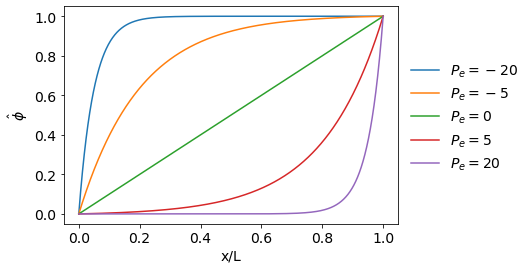

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

xL = np.linspace(0,1,1000)
def phihat(xL, Pe):
    return (np.exp(Pe*xL)-1)/(np.exp(Pe)-1)

plt.rc('font', size=14)
plt.plot(xL, phihat(xL,-20),   label=r'$P_e=-20$')
plt.plot(xL, phihat(xL,-5),    label=r'$P_e=-5$')
plt.plot(xL, phihat(xL,1E-12), label=r'$P_e=0$')
plt.plot(xL, phihat(xL,5),     label=r'$P_e=5$')
plt.plot(xL, phihat(xL,20),    label=r'$P_e=20$')
plt.legend(frameon=False, bbox_to_anchor=(1.0, 0.8))
plt.xlabel('x/L')
plt.ylabel(r'$\hat{\phi}$');



* Central differencing assumes the profile is linear (diffusion)
* Upwinding assumes the profile is constant (advection)
* Both of these are reasonable approximations in the limit of diffusion or or advection.
* We can use the exact solution to tell us **how** to choose the $\phi$ profile between the points.




**For mixed problems, we can do better by using the exact solution to construct an exact finite difference method.**

$$\frac{d\phi}{dx} = \frac{\Gamma}{u}\frac{d^2\phi}{dx^2} \rightarrow 
\frac{d}{dx}\underbrace{\left(u\phi - \Gamma\frac{d\phi}{dx}\right)}_{\mbox{Flux: F}} = 0.$$

Hence, our equation is 

$$\frac{dF}{dx} = 0.$$



For finite volume we have

$$F_e - F_w = 0.$$

$$F_e = u_e\phi_e - \Gamma_e\left(\frac{d\phi}{dx}\right)_e,$$
$$F_w = u_w\phi_w - \Gamma_w\left(\frac{d\phi}{dx}\right)_w.$$

* For a given face $e$, its right neighbor is E and its left neighbor is P. 
* Take these as known boundary conditions of the exact solution where $L=\Delta x$ is the grid spacing. 


* Solve our exact equation for $\phi$ and its derivative:

$$\phi = \phi_P + \underbrace{\left(\frac{\phi_E-\phi_P}{e^{P_e}-1}\right)}_{\gamma}(e^{P_ex/\Delta x}-1).$$

$$\frac{d\phi}{dx} = \gamma\frac{P_e}{\Delta x}(e^{P_ex/\Delta x}).$$

* Here, we are defining $\gamma$ for convenience.
* Now, we can insert these for $\phi_e$ and $(d\phi/dx)_e$ in our expression for $F_e$ above:

$$F_e = u_e\phi_e - \Gamma_e\left(\frac{d\phi}{dx}\right)_e,$$

$$F_e = u_e\phi_P + u_e\gamma(e^{P_ex/\Delta x}-1) - \gamma\underbrace{\frac{\Gamma_eP_e}{\Delta x}}_{u_e}(e^{P_ex/\Delta x}).$$

Here, we are using $(x/\Delta x)_e=1/2$, that is *Practice A*, where the face is midway between grid points. The above expression simplifies nicely (by cancellation of the exponential terms) to

$$F_e = u_e(\phi_P - \gamma),$$



Now, we insert $\gamma$, and repeat all of this for $F_w$ to obtain

<font color='blue'>
$$F_e = u_e\left(\phi_P + \frac{\phi_P-\phi_E}{e^{P_e}-1}\right).$$
</font>

<font color='blue'>
$$F_w = u_w\left(\phi_W + \frac{\phi_W-\phi_P}{e^{P_w}-1}\right).$$
</font>

* We're extending our notation so that now $P_e$ is the Peclet number on the east face and $P_w$ is the Peclet number on the west face.
* Also, we don't need a uniform grid, in defining the Peclet number, the length is the distance between grid cells splitting the respective face of interest.

**Finally,** for $F_e-F_w=0$ we can write our scheme in terms of coefficients of $\phi_W$, $\phi_P$ and $\phi_E$:

<font color='blue'>
$$
\phi_W\left[-u_w-\frac{u_w}{e^{P_w}-1}\right] +
\phi_P\left[u_e+\frac{u_e}{e^{P_e}-1} + \frac{u_w}{e^{P_w}-1}\right] +
\phi_E\left[\frac{-u_e}{e^{P_e}-1}\right] = 0.
$$
</font>

#### Question: 
If we know the exact solution, why bother going through the effort to use it in a finite volume method using a grid? Why not just use the solution?


We can use this method to treat the combined advection and diffusion fluxes $F$ for more complicated situations that we don't know (or don't want to find) the exact solution for. For example:
* Multi-dimensional,
* Unsteady,
* Complex source term.

## Exponentials are expensive

* Exponentials are computationally expensive to compute. 
    * [See this site, for example](https://streamcomputing.eu/blog/2012-07-16/how-expensive-is-an-operation-on-a-cpu/)
* Replace the exponential terms in the above coefficients with polynomial approximations.
    * The exponential terms above all look like 
    
    $$\frac{u}{e^P-1} = \frac{\Gamma}{\Delta x}\frac{P}{e^P-1}.$$
    
* Consider the last exponential term, call it $T$:

$$T = \frac{P}{e^P-1}.$$


* Patankar gives a non-exponential curve fit called the Hybrid Scheme:
    * $T=-P$ for $P<-2$
    * $T=1-P/2$ for $-2\le P \le  2$.
    * $T=0$ for $P>2$
* Patankar also gives a smoother polynomial fit (not shown here).

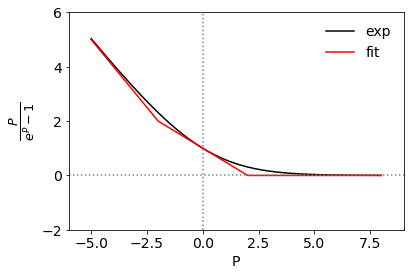

In [2]:
P = np.linspace(-5,8,1001)      # 1001 to avoid 0 in the list
T = P/(np.exp(P)-1)

Tfit = np.zeros(len(P))
Tfit[P<=2] = 1-0.5*P[P<=2]
Tfit[P<-2]     = -P[P<-2]

fig, ax = plt.subplots()
ax.plot(P,T,    'k-', label='exp')
ax.plot(P,Tfit, 'r-', label='fit')
plt.ylim([-2,6])
plt.xlim([-6,9])
ax.axvline(x=0, color='grey', ls=':')
ax.axhline(y=0, color='grey', ls=':')
plt.ylabel(r'$\frac{P}{e^P-1}$', fontsize='18')
plt.xlabel('P')
plt.legend(frameon=False);